In [1]:
!python --version

Python 3.11.13


In [1]:
import torch
import torch.nn as nn
import torchvision.models as models
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.models.detection import fasterrcnn_resnet50_fpn_v2
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.rpn import AnchorGenerator
from PIL import Image
import os
import matplotlib.pyplot as plt
# This is for the progress bar.
from tqdm import tqdm
import seaborn as sns
from pathlib import Path
import numpy as np
import pandas as pd
from collections import defaultdict
import argparse

torch.device('cuda')

device(type='cuda')

In [3]:
!nvidia-smi

Sat Oct 11 14:19:04 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-PCIE-16GB           Off |   00000000:00:04.0 Off |                    0 |
| N/A   35C    P0             27W /  250W |       0MiB /  16384MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [6]:
csv_path = "/kaggle/input/electrical-component/dataset/test/labels/IMG20240228125654_jpg.rf.9e9dbf556d80e21645e808b3edd44214.csv"
labels_dataframe = pd.read_csv(csv_path)
print(labels_dataframe.head(5))

   class  x_center  y_center  width  height
0     14       416       197    163      74
1     13       236       373     94     159
2      7       495       309     65     111


In [7]:
labels_dataframe.describe()

,class,x_center,y_center,width,height
count,3.000000,3.000000,3.00000,3.000000,3.000000
mean,11.333333,382.333333,293.00000,107.333333,114.666667
std,3.785939,132.741604,89.08423,50.342163,42.618462
min,7.000000,236.000000,197.00000,65.000000,74.000000
25%,10.000000,326.000000,253.00000,79.500000,92.500000
50%,13.000000,416.000000,309.00000,94.000000,111.000000
75%,13.500000,455.500000,341.00000,128.500000,135.000000
max,14.000000,495.000000,373.00000,163.000000,159.000000


In [2]:
# summarize data
# deprecated

def load_all_labels_and_summary(base_dir: str):
    base = Path(base_dir)
    splits = ["test"]  # "test"

    # 把所有CSV读到内存：键为 (split, stem)，值为 DataFrame
    labels_mem = {}
    class_to_files = defaultdict(set)   # 类别 -> 出现过该类别的 (split, stem) 集合
    class_inst_count = defaultdict(int) # 类别 -> 该类别的实例总数
    all_classes = set()

    total_files = 0             # CSV 文件总数（= 图像数）
    total_instances = 0         # 全部实例数

    for split in splits:
        lbl_dir = base / split / "labels"
        print(f"Loading {lbl_dir}")
        for csv_path in sorted(lbl_dir.glob("*.csv")):
            stem = csv_path.stem
            df = pd.read_csv(csv_path)
            labels_mem[(split, stem)] = df

            total_files += 1
            if len(df) > 0:
                # 统计每类的“文件数”和“实例数”
                for cls, g in df.groupby("class"):
                    cls = int(cls)
                    class_to_files[cls].add((split, stem))   # 文件去重
                    class_inst_count[cls] += len(g)
                    all_classes.add(cls)

            total_instances += len(df)

    # 输出汇总
    print("===== Dataset Summary =====")
    print(f"Total images (CSV files): {total_files}")
    print(f"Total object instances  : {total_instances}")
    print(f"Num classes             : {len(all_classes)}")

    print("\nPer-class summary (files_with_class, instance_count):")
    for cls in sorted(all_classes):
        print(f"  class {cls:>3}: files={len(class_to_files[cls])}, instances={class_inst_count[cls]}")

    # 如需返回数据以便后续使用
    return {
        "labels_mem": labels_mem,
        "class_to_files": class_to_files,
        "class_inst_count": class_inst_count,
        "all_classes": sorted(all_classes),
        "total_files": total_files,
        "total_instances": total_instances,
    }

# 示例调用
if __name__ == "__main__":
    _ = load_all_labels_and_summary("/kaggle/input/electrical-component/dataset/")


Loading /kaggle/input/electrical-component/dataset/test/labels
===== Dataset Summary =====
Total images (CSV files): 200
Total object instances  : 669
Num classes             : 27

Per-class summary (files_with_class, instance_count):
  class   0: files=6, instances=8
  class   1: files=90, instances=90
  class   2: files=17, instances=17
  class   4: files=19, instances=19
  class   5: files=11, instances=12
  class   6: files=1, instances=1
  class   7: files=27, instances=27
  class   9: files=20, instances=20
  class  10: files=23, instances=23
  class  11: files=18, instances=18
  class  13: files=24, instances=24
  class  14: files=22, instances=22
  class  15: files=89, instances=89
  class  16: files=2, instances=2
  class  17: files=2, instances=2
  class  18: files=82, instances=82
  class  19: files=87, instances=88
  class  20: files=5, instances=5
  class  21: files=8, instances=8
  class  22: files=4, instances=4
  class  23: files=24, instances=24
  class  25: files=1, i

===== Dataset Summary =====
Total images (CSV files):  1422
Total object instances  :  4896
Num classes             :  32


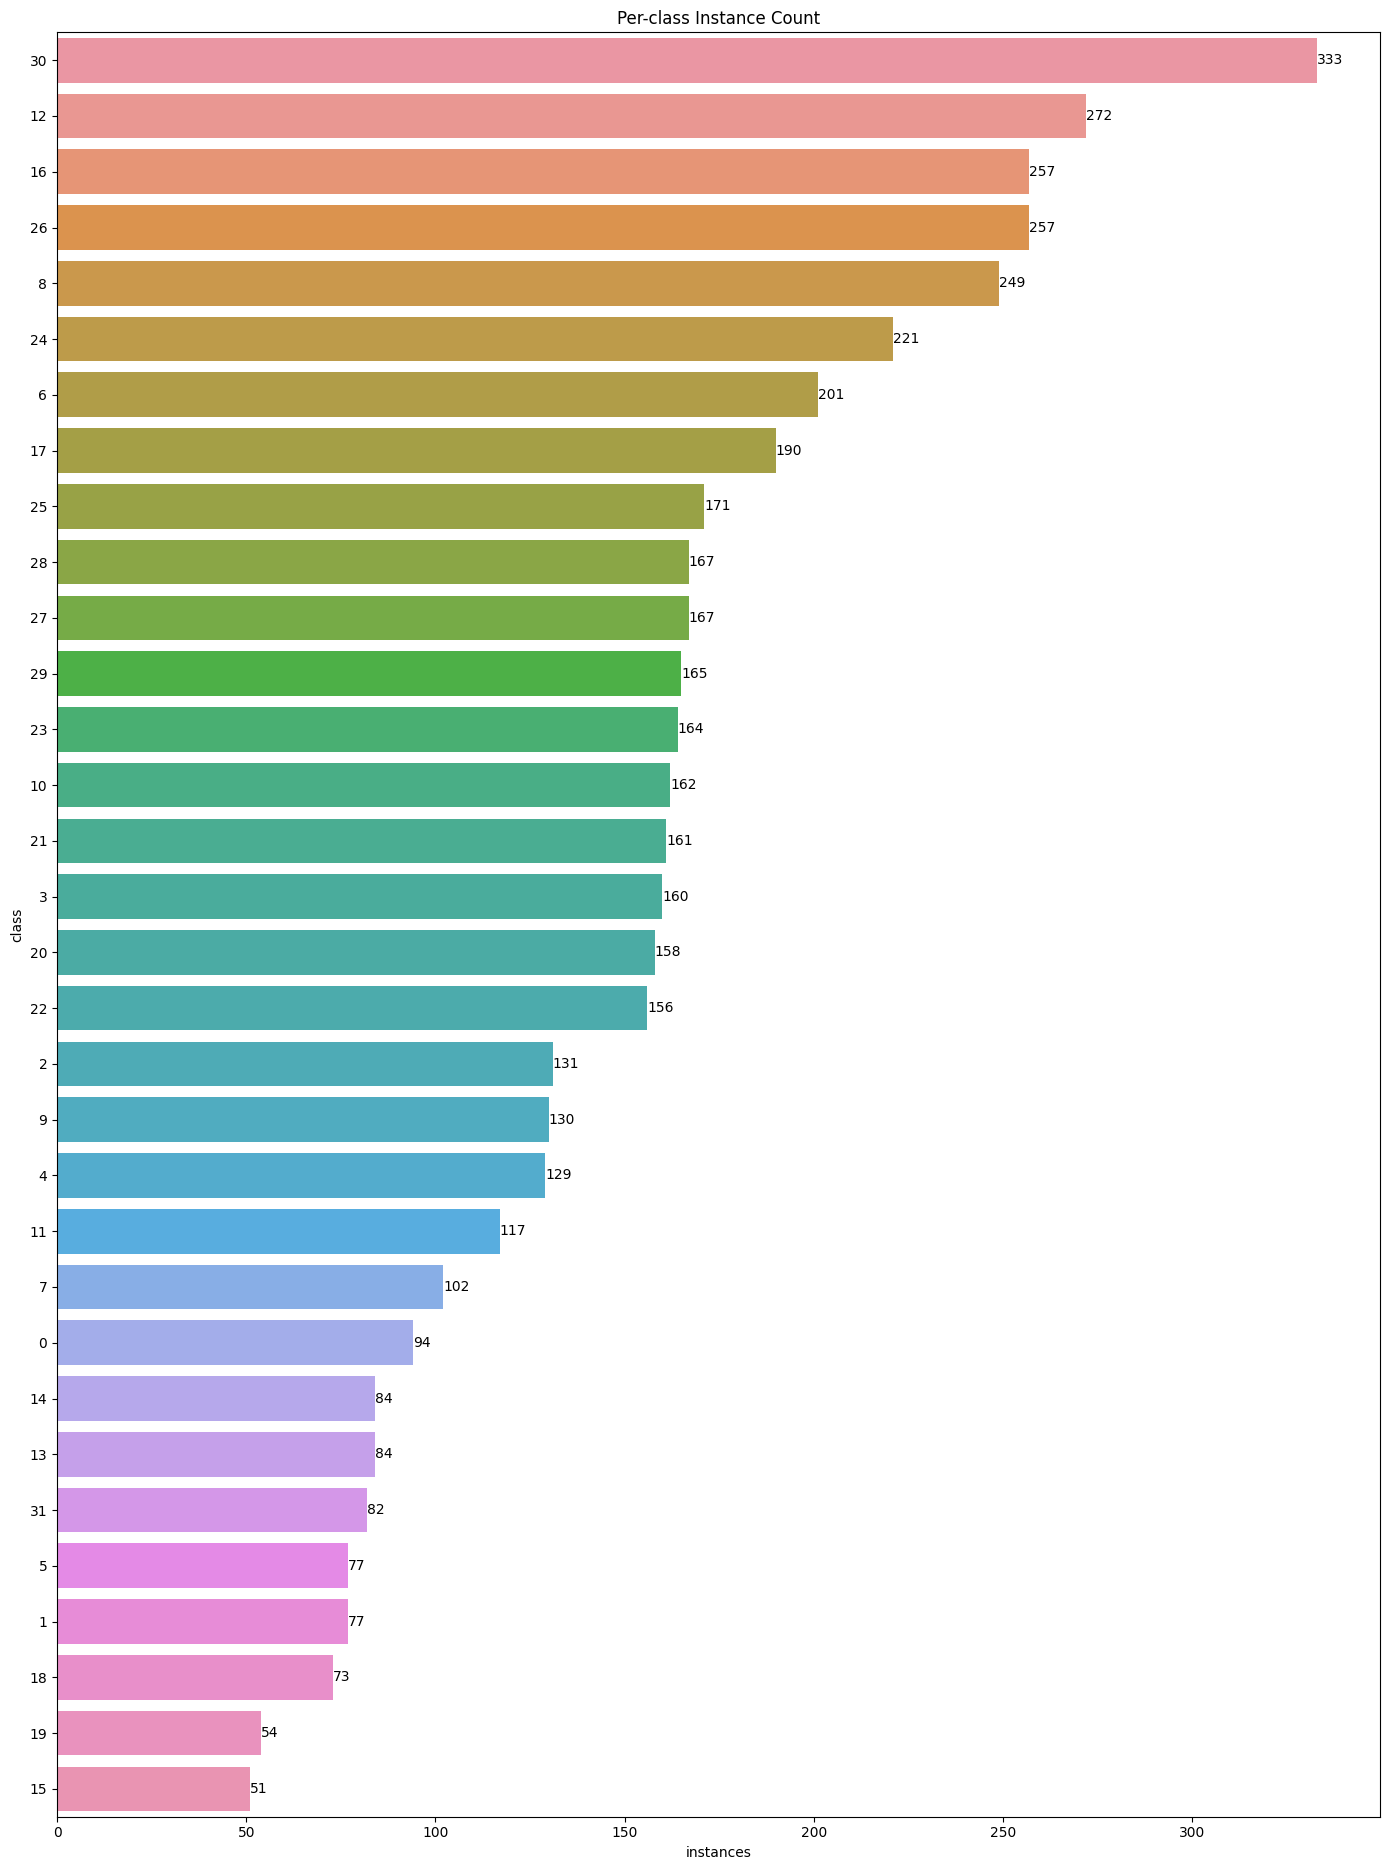

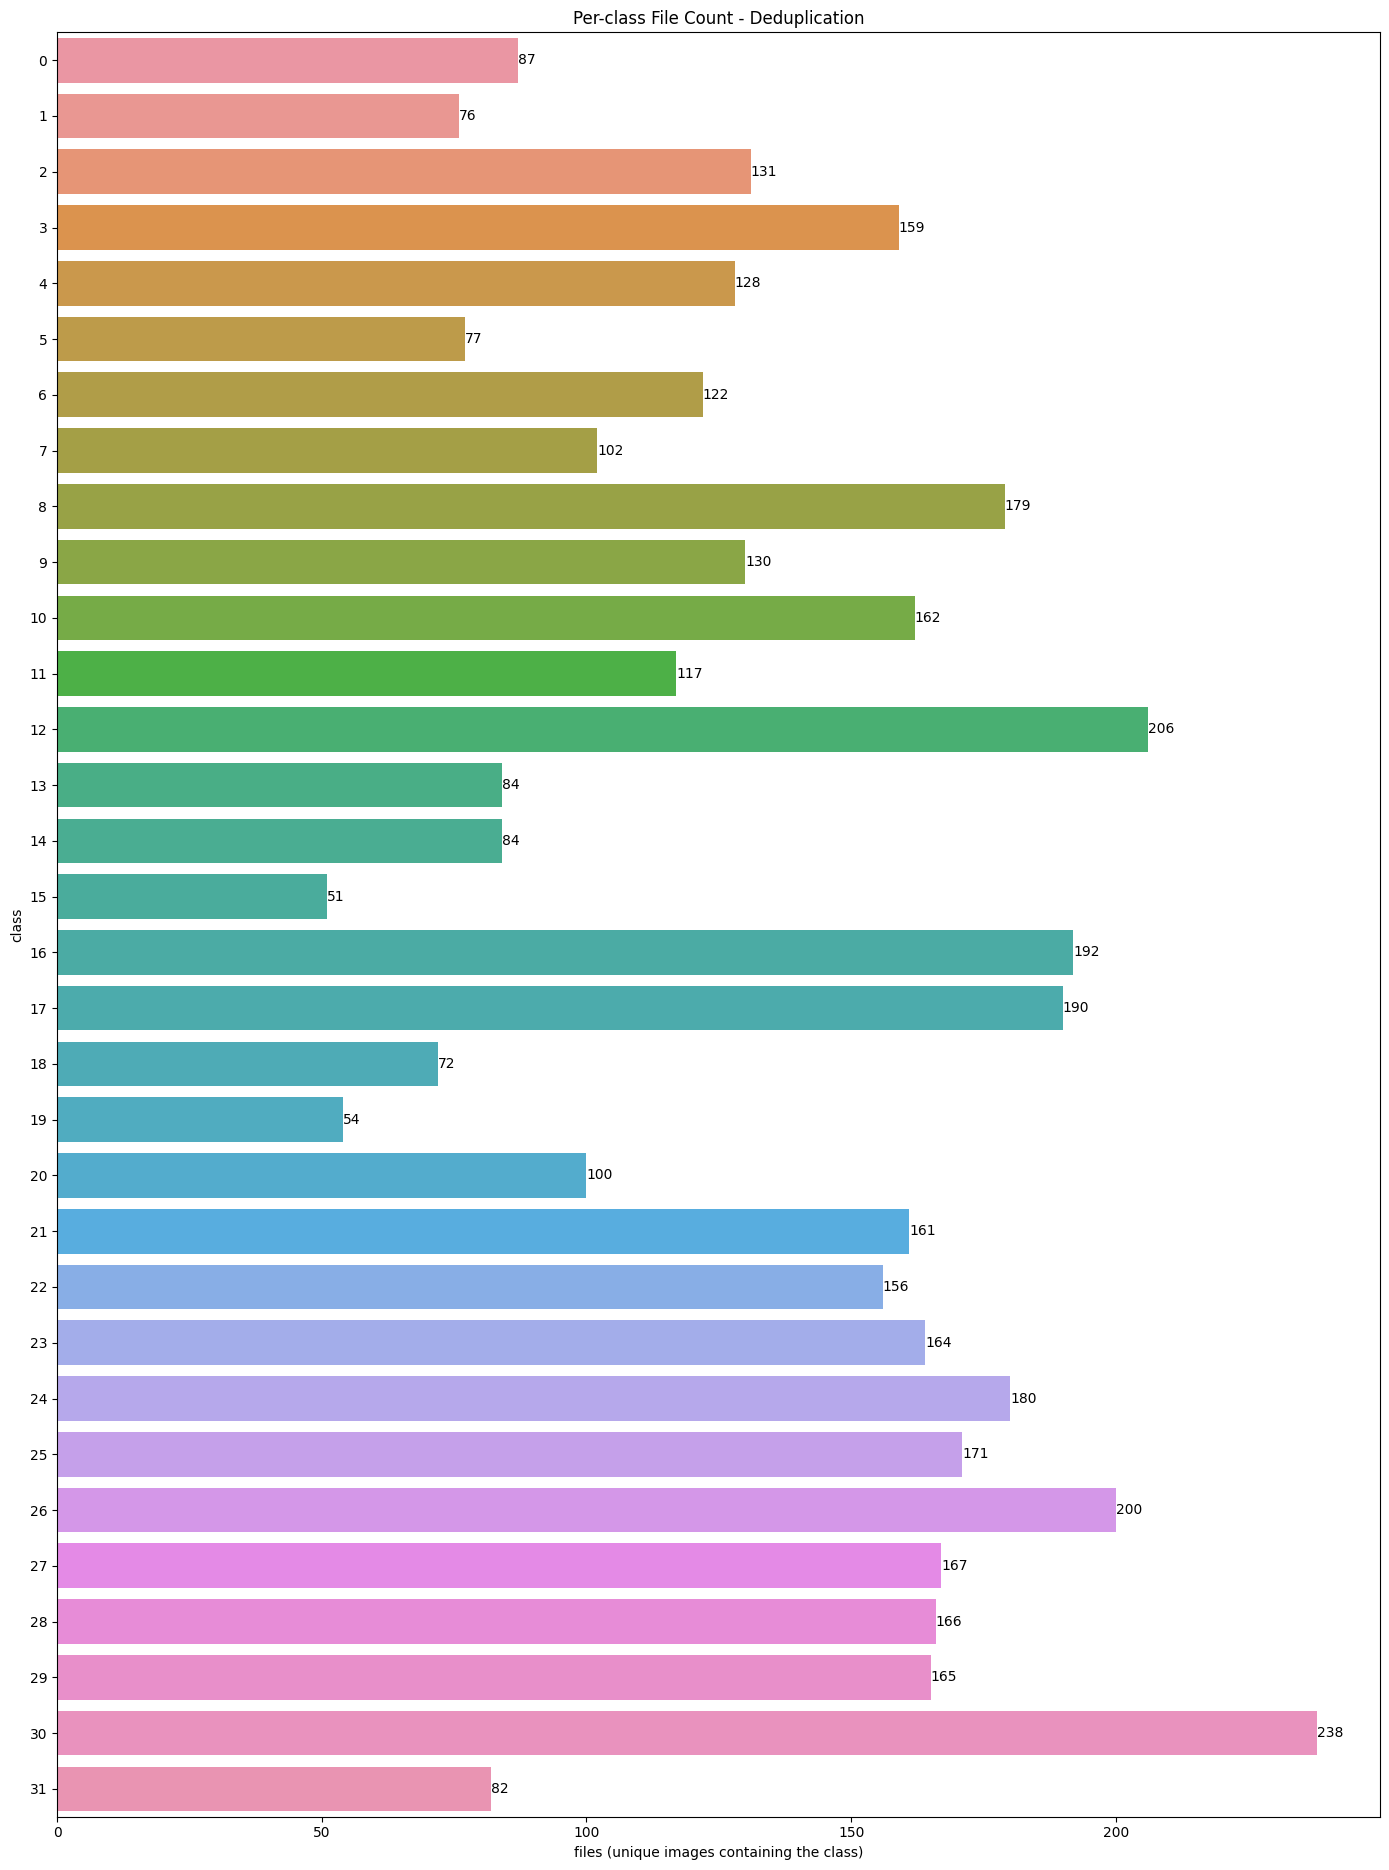

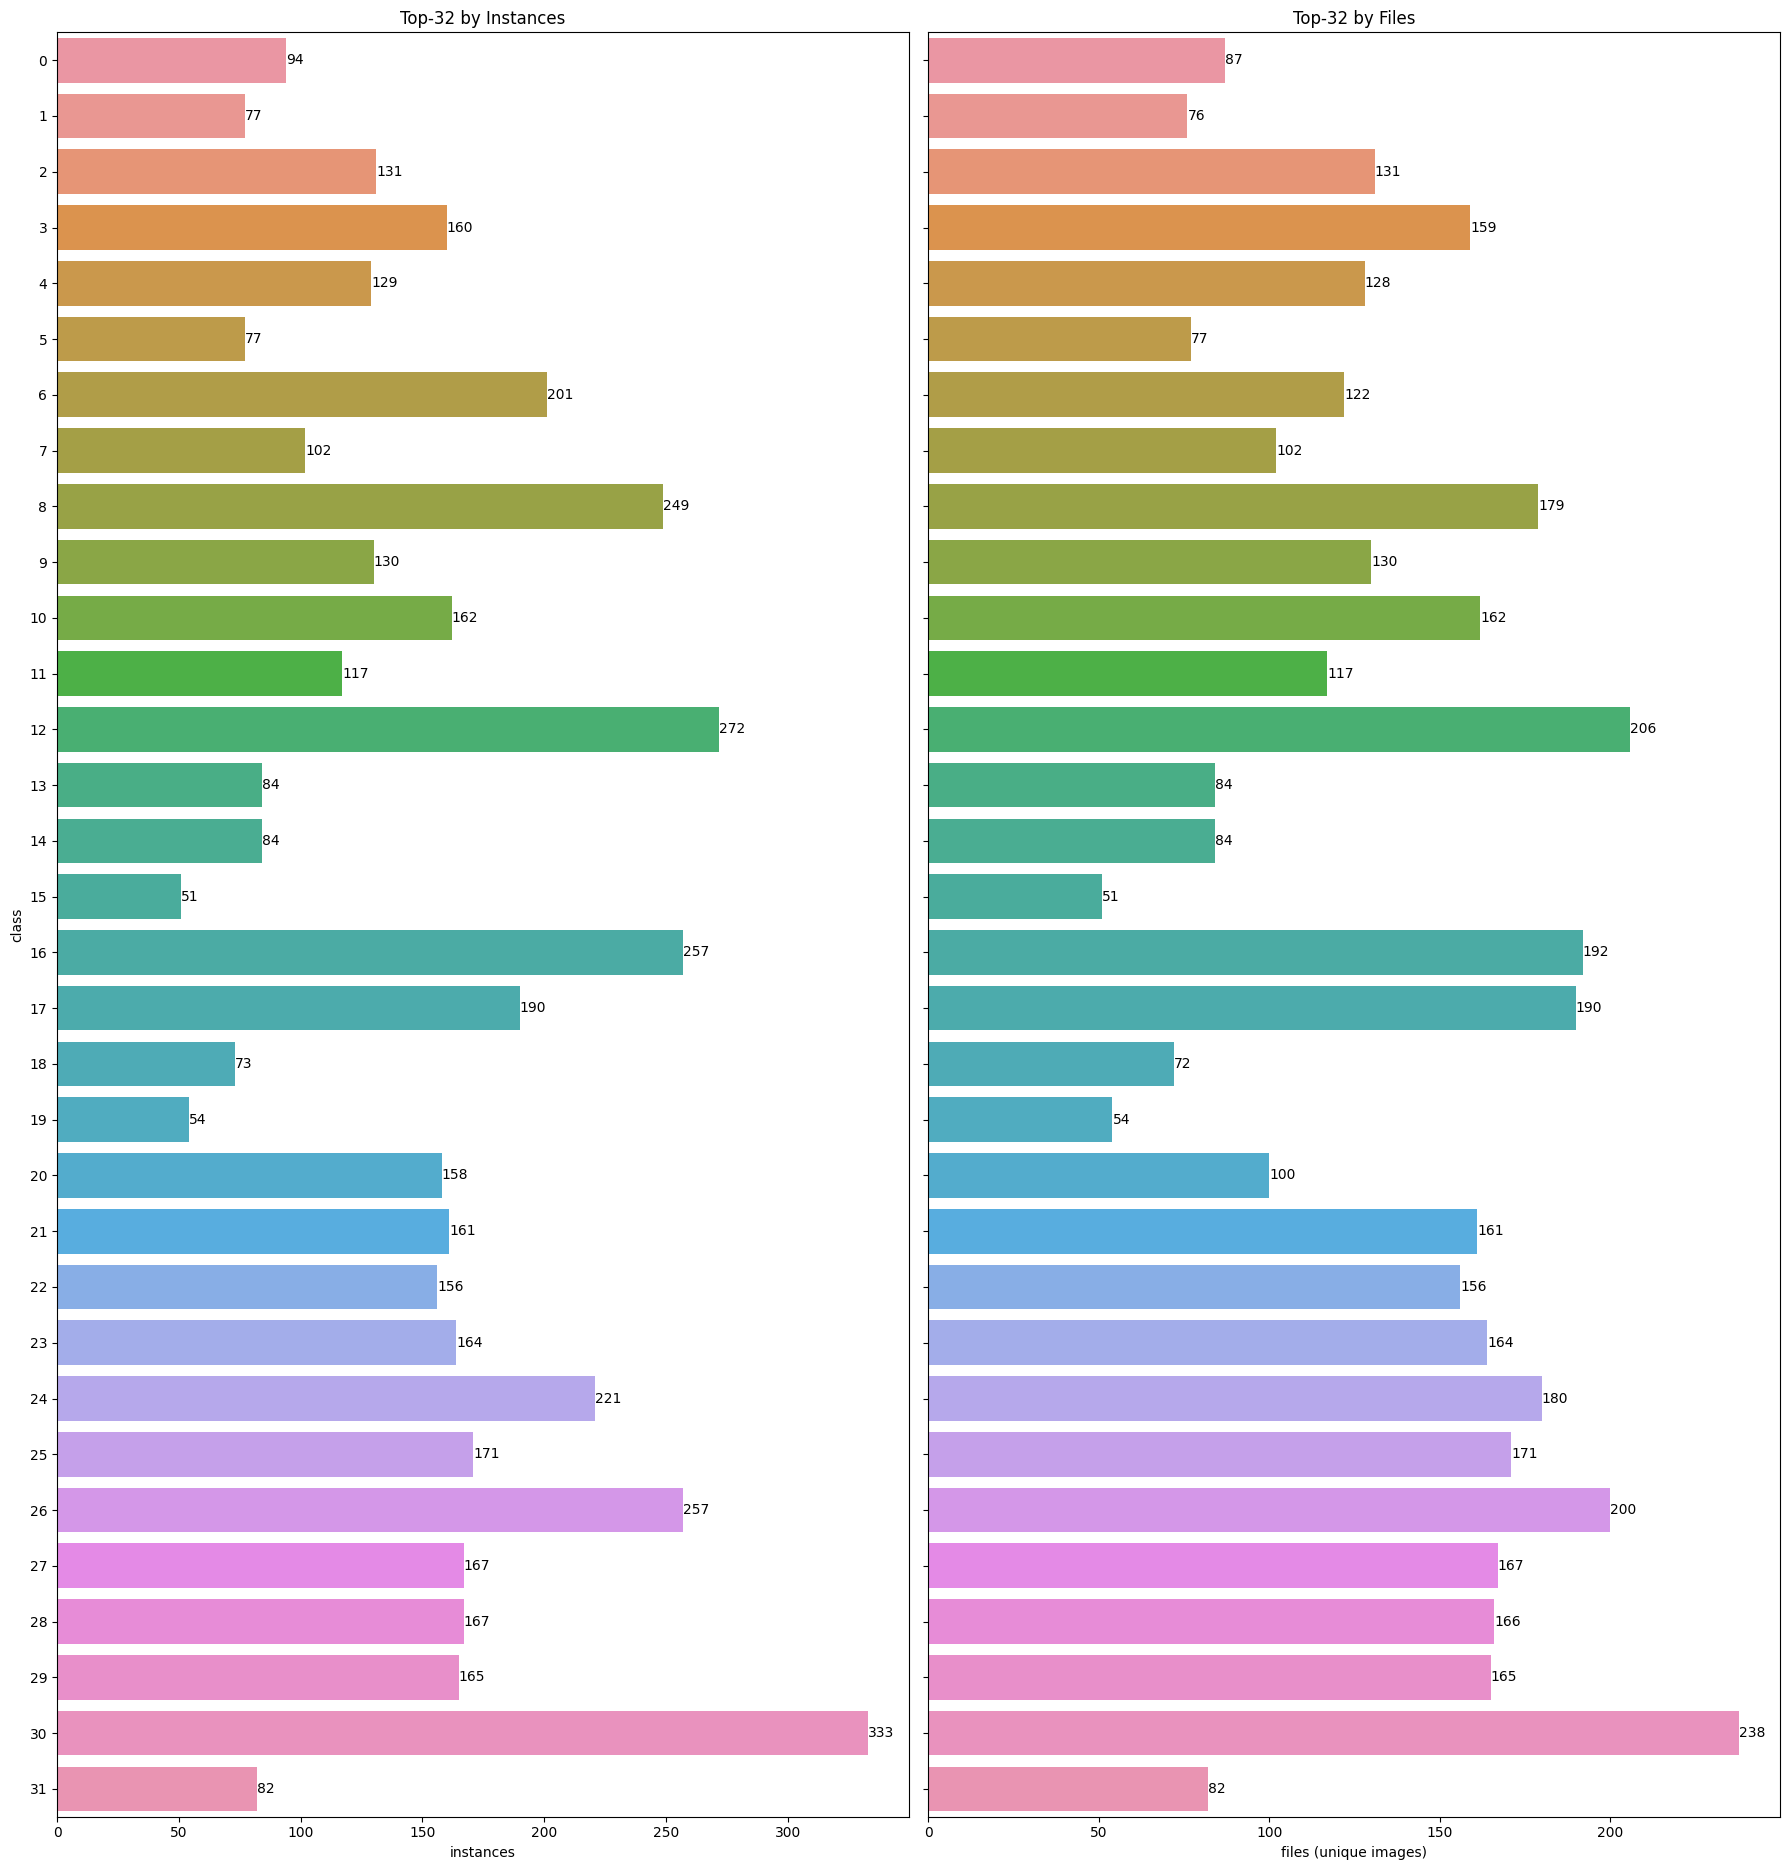

In [9]:
# visulize data
# -------- 载入所有 CSV -> 一个 DataFrame (labels_dataframe) --------
BASE = Path("/kaggle/input/electrical-component/dataset/")
splits = ["train"]

rows = []
for split in splits:
    for csv_path in (BASE / split / "labels").glob("*.csv"):
        stem = csv_path.stem
        df = pd.read_csv(csv_path)
        if len(df) == 0:
            continue
        df = df.copy()
        df["image"] = f"{split}/images/{stem}.npy"  # 记录图像路径/ID
        df["split"] = split
        rows.append(df[["class", "image", "split"]])

labels_dataframe = pd.concat(rows, ignore_index=True) if rows else pd.DataFrame(columns=["class","image","split"])

print("===== Dataset Summary =====")
print(f"Total images (CSV files): ", labels_dataframe["image"].nunique())
print(f"Total object instances  : ", len(labels_dataframe))
print(f"Num classes             : ", labels_dataframe["class"].nunique())

# -------- 你的条形标注函数 --------
def barw(ax):
    for p in ax.patches:
        val = p.get_width()
        x = p.get_x() + p.get_width()
        y = p.get_y() + p.get_height()/2
        ax.annotate(f"{val:.0f}", (x, y), va='center')

# -------- ① 每类的“实例数”可视化 --------
plt.figure(figsize=(14, 0.4 * labels_dataframe["class"].nunique() + 6))
ax0 = sns.countplot(
    y=labels_dataframe['class'],
    order=labels_dataframe['class'].value_counts().index
)
ax0.set_title("Per-class Instance Count")
ax0.set_xlabel("instances")
ax0.set_ylabel("class")
barw(ax0)
plt.tight_layout()
plt.show()

# -------- ② 每类覆盖的“文件数”(图像数) 可视化（去重 (label, image)）--------
files_per_class = (
    labels_dataframe[["class", "image"]]
      .drop_duplicates()                 # 去重同一张图里同一类的多实例
      .groupby("class")["image"]
      .nunique()
      .sort_values(ascending=False)
)

plt.figure(figsize=(14, 0.4 * len(files_per_class) + 6))
ax1 = sns.barplot(
    y=files_per_class.index,
    x=files_per_class.values,
    orient="h"
)
ax1.set_title("Per-class File Count - Deduplication")
ax1.set_xlabel("files (unique images containing the class)")
ax1.set_ylabel("class")
barw(ax1)
plt.tight_layout()
plt.show()

# -------- 只看 TOP-K 类别 --------
TOP_K = 32
top_instances = labels_dataframe['class'].value_counts().head(TOP_K)
top_files = files_per_class.head(TOP_K)

fig, (ax2, ax3) = plt.subplots(nrows=1, ncols=2, figsize=(18, 0.4 * TOP_K + 6), sharey=True)
sns.barplot(y=top_instances.index, x=top_instances.values, orient="h", ax=ax2)
ax2.set_title(f"Top-{TOP_K} by Instances")
ax2.set_xlabel("instances"); ax2.set_ylabel("class")
barw(ax2)

sns.barplot(y=top_files.index, x=top_files.values, orient="h", ax=ax3)
ax3.set_title(f"Top-{TOP_K} by Files")
ax3.set_xlabel("files (unique images)"); ax3.set_ylabel("")
barw(ax3)

plt.tight_layout()
plt.show()


In [10]:
torch.cuda.device_count()

1

In [7]:
# ResNet Module
class Residual(nn.Module):
  def __init__(self, input_channels, num_channels, use_1x1conv=False, strides=1):
    super().__init__()
    self.conv1 = nn.Conv2d(input_channels, num_channels, kernel_size=3, padding=1, stride=strides)
    self.conv2 = nn.Conv2d(num_channels, num_channels, kernel_size=3, padding=1)
    if use_1x1conv:
      self.conv3 = nn.Conv2d(input_channels, num_channels, kernel_size=1, stride=strides)
    else:
      self.conv3 = None
    self.bn1 = nn.BatchNorm2d(num_channels)
    self.bn2 = nn.BatchNorm2d(num_channels)

  def forward(self, X):
    Y = F.relu(self.bn1(self.conv1(X)))
    Y = self.bn2(self.conv2(Y))
    if self.conv3:
      X = self.conv3(X)
    Y += X
    return F.relu(Y)

def resnet_block(input_channels, num_channels, num_residuals, first_block=False):
  blk = []
  for i in range(num_residuals):
    if i == 0 and not first_block:
      blk.append(Residual(input_channels, num_channels, use_1x1conv=True, strides=2))
    else:
      blk.append(Residual(num_channels, num_channels))
  return blk

b1 = nn.Sequential(nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3),
                   nn.BatchNorm2d(64), nn.ReLU(),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))
b2 = nn.Sequential(*resnet_block(64, 64, 2, first_block=True))
b3 = nn.Sequential(*resnet_block(64, 128, 2))
b4 = nn.Sequential(*resnet_block(128, 256, 2))
b5 = nn.Sequential(*resnet_block(256, 512, 2))
net = nn.Sequential(b1, b2, b3, b4, b5,
                    nn.AdaptiveAvgPool2d((1,1)),
                    nn.Flatten(), nn.Linear(512, 10))

X = torch.rand(size=(1, 1, 224, 224))
for layer in net:
  X = layer(X)
  print(layer.__class__.__name__,'output shape:\t', X.shape)

Sequential output shape:	 torch.Size([1, 64, 56, 56])
Sequential output shape:	 torch.Size([1, 64, 56, 56])
Sequential output shape:	 torch.Size([1, 128, 28, 28])
Sequential output shape:	 torch.Size([1, 256, 14, 14])
Sequential output shape:	 torch.Size([1, 512, 7, 7])
AdaptiveAvgPool2d output shape:	 torch.Size([1, 512, 1, 1])
Flatten output shape:	 torch.Size([1, 512])
Linear output shape:	 torch.Size([1, 10])


In [8]:
# faster RCNN resnet50

def _largest_ndarray(obj):
    if isinstance(obj, dict):
        for k in ("image","img","array","data","X","arr"):
            if k in obj and isinstance(obj[k], np.ndarray):
                return obj[k]
        cands = [v for v in obj.values() if isinstance(v, np.ndarray)]
        return max(cands, key=lambda a: a.size)
    if isinstance(obj, (list, tuple)):
        cands = [v for v in obj if isinstance(v, np.ndarray)]
        return max(cands, key=lambda a: a.size)
    return obj

def load_image_hwc_uint8(npy_path: str) -> np.ndarray:
    """
    假设 .npy 存的是 HWC, ndim=3。
    - 若 dtype 非 uint8, 自动判断 0~1 / -1~1 并映射到 0~255
    - 若为单通道或带 alpha, 自动处理到 3 通道 RGB
    """
    a = np.load(npy_path, allow_pickle=False)  # 已知是 HWC, ndim=3
    if a.dtype != np.uint8:
        a = a.astype(np.float32, copy=False)
        vmin, vmax = float(a.min()), float(a.max())
        if 0.0 <= vmin and vmax <= 1.0:
            a = (a * 255.0).round()
        elif -1.0 <= vmin and vmax <= 1.0:
            a = ((a + 1.0) * 0.5 * 255.0).round()
        # 否则认为已经接近 0..255，不再缩放
        a = np.clip(a, 0, 255).astype(np.uint8)

    # 通道处理：1通道 -> 3通道；4通道 -> 丢 alpha
    c = a.shape[2]
    if c == 1:
        a = np.repeat(a, 3, axis=2)
    elif c == 4:
        a = a[..., :3]
    return a  # HWC uint8(3)

class NpyDetDataset(Dataset):
    """
    返回：
      image: FloatTensor [3,H,W] (0..1)
      target: dict(boxes: [N,4] xyxy, labels: [N], image_id, size=[H,W])
    """
    def __init__(self, base_dir, split="train", transform=None):
        base = Path(base_dir)
        self.img_dir = base / split / "images"
        self.lbl_dir = base / split / "labels"
        self.stems = sorted([p.stem for p in self.lbl_dir.glob("*.csv")])
        self.transform = transform

        # 一次性把所有 CSV 读到内存，避免训练期I/O瓶颈
        self.ann = {s: pd.read_csv(self.lbl_dir / f"{s}.csv") for s in self.stems}

    def __len__(self):
        return len(self.stems)

    def __getitem__(self, idx):
        stem = self.stems[idx]
        img_path = self.img_dir / f"{stem}.npy"
        img = load_image_hwc_uint8(img_path)
        h, w = img.shape[:2]

        df = self.ann[stem].copy()
        x_c = df["x_center"].astype("float32").to_numpy()
        y_c = df["y_center"].astype("float32").to_numpy()
        bw  = df["width"].astype("float32").to_numpy()
        bh  = df["height"].astype("float32").to_numpy()

        # 自动识别是否为归一化
        if x_c.max() <= 1.0 and y_c.max() <= 1.0 and bw.max() <= 1.0 and bh.max() <= 1.0:
            x_c *= w; y_c *= h; bw *= w; bh *= h

        x1 = x_c - bw/2; y1 = y_c - bh/2
        x2 = x_c + bw/2; y2 = y_c + bh/2
        boxes = np.stack([x1,y1,x2,y2], axis=1)
        boxes[:, [0,2]] = boxes[:, [0,2]].clip(0, w)
        boxes[:, [1,3]] = boxes[:, [1,3]].clip(0, h)

        labels = df["class"].astype("int64").to_numpy()

        img_t = torch.from_numpy(img).permute(2,0,1).float() / 255.0
        target = {
            "boxes":  torch.from_numpy(boxes).float(),
            "labels": torch.from_numpy(labels).long(),
            "image_id": torch.tensor([idx]),
            "size": torch.tensor([h,w])
        }

        if self.transform is not None:
            img_t, target = self.transform(img_t, target)
        return img_t, target

def det_collate_fn(batch):
    imgs, targets = list(zip(*batch))
    return list(imgs), list(targets)

def build_model(num_classes, small_object=False):
    # 预训练 Faster R-CNN + ResNet50-FPN
    model = fasterrcnn_resnet50_fpn_v2(weights="DEFAULT", weights_backbone="DEFAULT")

    # 可选：更小的 anchors，利于小目标
    if small_object:
        # 对 FPN 的 5 个特征层分别设定 anchor 尺寸
        anchor_sizes = ((16,), (32,), (64,), (128,), (256,))
        aspect_ratios = ((0.5, 1.0, 2.0),) * len(anchor_sizes)
        model.rpn.anchor_generator = AnchorGenerator(sizes=anchor_sizes,
                                                     aspect_ratios=aspect_ratios)

    # 换分类头（num_classes 包含 background）
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model

def box_iou_np(boxes1, boxes2):
    """boxes: [N,4] & [M,4] in xyxy -> IoU [N,M]"""
    if len(boxes1)==0 or len(boxes2)==0:
        return np.zeros((len(boxes1), len(boxes2)), dtype=np.float32)
    x11,y11,x12,y12 = boxes1[:,0],boxes1[:,1],boxes1[:,2],boxes1[:,3]
    x21,y21,x22,y22 = boxes2[:,0],boxes2[:,1],boxes2[:,2],boxes2[:,3]
    inter_w = np.maximum(0, np.minimum(x12, x22) - np.maximum(x11, x21))
    inter_h = np.maximum(0, np.minimum(y12, y22) - np.maximum(y11, y21))
    inter = inter_w * inter_h
    area1 = np.maximum(0, x12-x11) * np.maximum(0, y12-y11)
    area2 = np.maximum(0, x22-x21) * np.maximum(0, y22-y21)
    union = area1[:,None] + area2[None,:] - inter
    return inter / np.clip(union, 1e-6, None)

def train_one_epoch(model, loader, optimizer, device, scaler=None):
    model.train()
    loss_sum = 0.0
    for imgs, targets in loader:
        imgs = [img.to(device) for img in imgs]
        targets = [{k: v.to(device) for k,v in t.items()} for t in targets]

        optimizer.zero_grad(set_to_none=True)
        if scaler:
            with torch.autocast(device_type=device, dtype=torch.float16 if device=='cuda' else torch.bfloat16):
                loss_dict = model(imgs, targets)
                losses = sum(loss_dict.values())
            scaler.scale(losses).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            loss_dict = model(imgs, targets)
            losses = sum(loss_dict.values())
            losses.backward()
            optimizer.step()

        loss_sum += losses.item()
    return loss_sum / max(1, len(loader))

BLOCKED = {3, 8, 12, 24, 26}  

def filter_predictions(preds, blocked=BLOCKED, class_thresholds=None):
    """
    preds: list of dicts from torchvision (boxes, labels, scores)
    blocked: 需要完全屏蔽的类别
    class_thresholds: 可选，dict{cls:thr} 每类不同分数阈值
    """
    out = []
    for p in preds:
        labels = p["labels"].cpu().numpy()
        scores = p["scores"].cpu().numpy()
        keep = [i for i, (c, s) in enumerate(zip(labels, scores))
                if (c not in blocked) and (class_thresholds is None or s >= class_thresholds.get(int(c), 0.05))]
        q = {k: v[keep] for k,v in p.items() if k in ("boxes","labels","scores")}
        out.append(q)
    return out

@torch.no_grad()
def evaluate_loss_and_pr(
    model,
    loader,
    device,
    num_classes: int,
    iou_thresh: float = 0.5,
    score_thresh: float = 0.05,
):
    """
    适用于 torchvision 检测模型（Faster R-CNN 等）
    - 假设类别 id 为 0..num_classes-1（无“背景类”标签）
    - 返回：{'loss', 'TP','FP','FN','precision','recall'}
    """
    was_training = model.training

    loss_sum = 0.0
    n_loss_batches = 0
    TP = np.zeros(num_classes, dtype=np.int64)
    FP = np.zeros(num_classes, dtype=np.int64)
    FN = np.zeros(num_classes, dtype=np.int64)

    for imgs, targets in loader:
        imgs_dev = [im.to(device) for im in imgs]
        targets_dev = [{k: v.to(device) for k, v in t.items()} for t in targets]

        # ---- 1) 计算验证 loss（需 train() 才会返回 loss dict）----
        model.train()
        loss_dict = model(imgs_dev, targets_dev)
        loss_val = sum(loss_dict.values()).item()
        loss_sum += loss_val
        n_loss_batches += 1

        # ---- 2) 做预测并统计 per-class PR（需 eval()）----
        model.eval()
        raw_preds = model(imgs_dev)
        preds = filter_predictions(raw_preds)
        

        for pred, tgt in zip(preds, targets_dev):
            pb = pred["boxes"].detach().cpu().numpy()
            pl = pred["labels"].detach().cpu().numpy()
            ps = pred["scores"].detach().cpu().numpy()

            # 置信度过滤（可调）
            keep = ps >= score_thresh
            pb, pl, ps = pb[keep], pl[keep], ps[keep]

            tb = tgt["boxes"].detach().cpu().numpy()
            tl = tgt["labels"].detach().cpu().numpy()

            # 按类别逐一匹配
            for c in range(num_classes):
                pb_c = pb[pl == c]
                ps_c = ps[pl == c]
                tb_c = tb[tl == c]

                if len(pb_c) == 0 and len(tb_c) == 0:
                    continue
                if len(tb_c) == 0:
                    FP[c] += len(pb_c)
                    continue
                if len(pb_c) == 0:
                    FN[c] += len(tb_c)
                    continue

                order = np.argsort(-ps_c)  # 先匹配高分框
                pb_c = pb_c[order]
                iou = box_iou_np(pb_c, tb_c)

                matched = set()
                for i in range(len(pb_c)):
                    j = int(np.argmax(iou[i]))
                    if iou[i, j] >= iou_thresh and j not in matched:
                        TP[c] += 1
                        matched.add(j)
                    else:
                        FP[c] += 1
                FN[c] += (len(tb_c) - len(matched))

    # 恢复原模式
    model.train() if was_training else model.eval()

    precision = TP / np.clip(TP + FP, 1, None)
    recall    = TP / np.clip(TP + FN, 1, None)
    mean_loss = loss_sum / max(1, n_loss_batches)

    return {
        "loss": mean_loss,
        "TP": TP,
        "FP": FP,
        "FN": FN,
        "precision": precision,
        "recall": recall,
    }


In [9]:
#main function

def main():
    ap = argparse.ArgumentParser()
    ap.add_argument("--base", default="/kaggle/input/electrical-component/dataset/", help="root directory")
    ap.add_argument("--bs", type=int, default=2)
    ap.add_argument("--epochs", type=int, default=10)
    ap.add_argument("--lr", type=float, default=1e-4)
    ap.add_argument("--small-object", action="store_true", help="smaller anchors")
    args = ap.parse_args([]) # Pass an empty list to avoid parsing notebook arguments

    train_set = NpyDetDataset(args.base, split="train")
    test_set  = NpyDetDataset(args.base, split="test")

    train_loader = DataLoader(train_set, batch_size=args.bs, shuffle=True,
                              num_workers=2, pin_memory=True, collate_fn=det_collate_fn)
    test_loader  = DataLoader(test_set,  batch_size=args.bs, shuffle=False,
                              num_workers=2, pin_memory=True, collate_fn=det_collate_fn)

    device = "cuda" if torch.cuda.is_available() else "cpu"
    model = build_model(32, small_object=args.small_object).to(device)

    optimizer = torch.optim.AdamW(model.parameters(), lr=args.lr, weight_decay=1e-3)
    scaler = torch.amp.GradScaler('cuda', enabled=(device=="cuda"))

    best_val = float("inf")
    for epoch in range(1, args.epochs + 1):
        tr = train_one_epoch(model, train_loader, optimizer, device, scaler)
        va = evaluate_loss_and_pr(model, test_loader, device, num_classes=32,      # 你的类别数
        iou_thresh=0.5,      # PR 的 IoU 阈值
        score_thresh=0.2     # 置信度过滤
)
        print(f"Epoch {epoch:02d} | train loss {tr:.4f} | val loss {va['loss']:.4f}")
        for c in range(32):
          print(f"class {c:02d} | P={va['precision'][c]:.3f} "
          f"R={va['recall'][c]:.3f}  TP={va['TP'][c]} FP={va['FP'][c]} FN={va['FN'][c]}")
        if va['loss'] < best_val:
            best_val = va['loss']
            torch.save(model.state_dict(), "best_frcnn_resnet50fpn.pt")
            print("  (saved best)")

main() # Call the main function directly

Epoch 01 | train loss 0.6304 | val loss 0.5309
class 00 | P=0.000 R=0.000  TP=0 FP=0 FN=8
class 01 | P=0.735 R=0.922  TP=83 FP=30 FN=7
class 02 | P=0.447 R=1.000  TP=17 FP=21 FN=0
class 03 | P=0.000 R=0.000  TP=0 FP=0 FN=0
class 04 | P=0.514 R=1.000  TP=19 FP=18 FN=0
class 05 | P=0.155 R=0.750  TP=9 FP=49 FN=3
class 06 | P=0.040 R=1.000  TP=1 FP=24 FN=0
class 07 | P=0.575 R=0.852  TP=23 FP=17 FN=4
class 08 | P=0.000 R=0.000  TP=0 FP=0 FN=0
class 09 | P=0.267 R=1.000  TP=20 FP=55 FN=0
class 10 | P=0.167 R=0.913  TP=21 FP=105 FN=2
class 11 | P=0.375 R=1.000  TP=18 FP=30 FN=0
class 12 | P=0.000 R=0.000  TP=0 FP=0 FN=0
class 13 | P=0.514 R=0.792  TP=19 FP=18 FN=5
class 14 | P=0.684 R=0.591  TP=13 FP=6 FN=9
class 15 | P=0.778 R=0.157  TP=14 FP=4 FN=75
class 16 | P=0.033 R=1.000  TP=2 FP=58 FN=0
class 17 | P=0.000 R=0.000  TP=0 FP=61 FN=2
class 18 | P=0.871 R=0.659  TP=54 FP=8 FN=28
class 19 | P=1.000 R=0.568  TP=50 FP=0 FN=38
class 20 | P=0.147 R=1.000  TP=5 FP=29 FN=0
class 21 | P=0.074 R=